In [167]:
%%capture
!pip install google-cloud-storage
!pip install --upgrade google-cloud-bigquery
!pip install pyarrow
!pip install spacy
!pip install swifter

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/root/Udacity-ML-Engineer-Capstone-Project/credentials/Google_bigquery_auth.json"

In [4]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client()

QUERY = """
        SELECT committer.name, committer.time_sec, subject, message
        FROM `bigquery-public-data.github_repos.commits`
        WHERE LENGTH(message) > 6 AND LENGTH(message) <= 200
        LIMIT 4000000
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=200)
rows = list(iterator)

commit_messages = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
commit_messages["first_segment_message"] = commit_messages["message"].str.split("\n\n").str.get(0) # split by \n\n too see if there are multiple segment commit message
print(f"Fetched {commit_messages.shape[0]} Records")
# Look at the first 10 headlines
display(commit_messages.head(10))

Fetched 4000000 Records


,name,time_sec,subject,message,first_segment_message
0,juhosg,1395903771,packages/devio: fix whitespaces,packages/devio: fix whitespaces\n\nSigned-off-...,packages/devio: fix whitespaces
1,Тукаев Александр Юрьевич,1393580313,Main -> Prerelease (ERM-3214),Main -> Prerelease (ERM-3214)\n\ngit-tfs-id: [...,Main -> Prerelease (ERM-3214)
2,Andreas Kleen,1077799544,Lots of updates,Lots of updates\n\nsuse-commit: a4cdcf59ad21c9...,Lots of updates
3,android-build-merger,1469741041,"Merge \""Responsive caret drawable\"" into ub-la...","Merge \""Responsive caret drawable\"" into ub-la...","Merge \""Responsive caret drawable\"" into ub-la..."
4,lastclick,1209342182,fix (?=$) to $ http://forums.openkore.com/view...,fix (?=$) to $\nhttp://forums.openkore.com/vie...,fix (?=$) to $\nhttp://forums.openkore.com/vie...
5,Fabien Balageas,1322494537,close #2558 - removed unneeded Save dialog in ...,close #2558 - removed unneeded Save dialog in ...,close #2558 - removed unneeded Save dialog in ...
6,David Cournapeau,1214729790,"Initialized merge tracking via ""svnmerge"" with...","Initialized merge tracking via ""svnmerge"" with...","Initialized merge tracking via ""svnmerge"" with..."
7,OpenStack Jenkins,1385964015,Imported Translations from Transifex,Imported Translations from Transifex\n\nChange...,Imported Translations from Transifex
8,Тукаев Александр Юрьевич,1409895634,[NA] Core/Prerelease RI,[NA] Core/Prerelease RI\n\ngit-tfs-id: [http:/...,[NA] Core/Prerelease RI
9,Hans Wennborg,1309452583,svn propdel svn:eol-style test/Sema/return.cpp,svn propdel svn:eol-style test/Sema/return.cpp...,svn propdel svn:eol-style test/Sema/return.cpp


In [5]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
os.makedirs(data_dir, exist_ok = True)

commit_messages.to_parquet(data_path)
print(f"Saved the dataset to {data_path}")

Saved the dataset to ./data/commit_messages.parquet


### EDA of the data 
Can be run independently against previous section

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pd.options.plotting.backend="plotly"

In [7]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")

In [8]:
commit_messages = pd.read_parquet(data_path)
print(commit_messages.shape)

(4000000, 5)


In [24]:
# NA Checking
commit_messages.isna().sum()

name                         0
time_sec                     0
subject                      0
message                      0
first_segment_message        0
subject_len                  0
message_len                  0
first_segment_message_len    0
dtype: int64

In [10]:
commit_messages.head()

,name,time_sec,subject,message,first_segment_message
0,juhosg,1395903771,packages/devio: fix whitespaces,packages/devio: fix whitespaces\n\nSigned-off-...,packages/devio: fix whitespaces
1,Тукаев Александр Юрьевич,1393580313,Main -> Prerelease (ERM-3214),Main -> Prerelease (ERM-3214)\n\ngit-tfs-id: [...,Main -> Prerelease (ERM-3214)
2,Andreas Kleen,1077799544,Lots of updates,Lots of updates\n\nsuse-commit: a4cdcf59ad21c9...,Lots of updates
3,android-build-merger,1469741041,"Merge \""Responsive caret drawable\"" into ub-la...","Merge \""Responsive caret drawable\"" into ub-la...","Merge \""Responsive caret drawable\"" into ub-la..."
4,lastclick,1209342182,fix (?=$) to $ http://forums.openkore.com/view...,fix (?=$) to $\nhttp://forums.openkore.com/vie...,fix (?=$) to $\nhttp://forums.openkore.com/vie...


In [11]:
identical_ratio = (commit_messages["subject"].values == commit_messages["message"].values).sum() / commit_messages.shape[0]
print("{:.2f}% of Subjects are totally identical to commit messages".format(100 * identical_ratio))

10.97% of Subjects are totally identical to commit messages


In [12]:
identical_ratio = (commit_messages["subject"].values == commit_messages["first_segment_message"].values).sum() / commit_messages.shape[0]
print("{:.2f}% of Subjects are totally identical to the first segment of the message".format(100 * identical_ratio))

30.58% of Subjects are totally identical to the first segment of the message


In [13]:
segmented_message_ratio = commit_messages["message"].map(lambda x: "\n\n" in x).sum() / commit_messages.shape[0]
print("{:.2f}% of Message has multiple segment if split by '\\n\\n'".format(100 * segmented_message_ratio))

20.28% of Message has multiple segment if split by '\n\n'


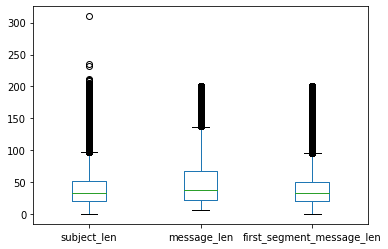

In [15]:
# Commit Message & Subject Length Distribution
fig, axes = plt.subplots()
commit_messages["subject_len"] = commit_messages["subject"].str.len()
commit_messages["message_len"] = commit_messages["message"].str.len()
commit_messages["first_segment_message_len"] = commit_messages["message"].str.split("\n").str.get(0).str.len()
commit_messages.plot.box(y=["subject_len", "message_len", "first_segment_message_len"], ax=axes)

### Build Rule System that create dependent variable
Can be run independently against previous section

In [169]:
import pandas as pd
import swifter
import numpy as np
import spacy

In [42]:
%%capture
# !python -m spacy download en_core_web_sm
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [47]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [19]:
data_dir = "./data/"
data_path = os.path.join(data_dir, "commit_messages.parquet")
usecols = ["name", "subject", "first_segment_message"]

In [25]:
commit_messages = pd.read_parquet(data_path, columns = usecols)
print(commit_messages.shape)

(4000000, 3)


In [197]:
raw_identifiers = ["fix", "update", "rework", "merge", "add", "polish", \
                   "resolve", "rename", "refactor", "remove", "implement"]
identifiers = set([nlp(word)[0].lemma_ for word in identifiers])
print(identifiers)

{'rename', 'add', 'merge', 'remove', 'polish', 'resolve', 'rework', 'fix', 'update', 'implement', 'refactor'}


In [187]:
def create_dependant_variable(row, debug=False):
    message_doc = nlp(row["first_segment_message"])
    subject_doc = nlp(row["subject"])
    
    identifier_exist = None
    not_overlength = None
    capitalized_first_token = None
    not_period_end = None
    first_alpha_word_verb = None
    
    try:
        if message_doc.__len__() > 0 and subject_doc.__len__() > 0:
            identifier_exist = False
            for token in subject_doc:
                if token.lemma_ in identifiers:
                    identifier_exist = True
                    break
                else:
                    continue
            if identifier_exist is False:
                for token in message_doc:
                    if token.lemma_ in identifiers:
                        identifier_exist = True
                        break
                    else:
                        continue
            not_overlength = message_doc.__len__() <= 50
            capitalized_first_token = message_doc[0].is_title
            not_period_end = message_doc[-1].text == "."
            first_alpha_word_verb = False
            for token in message_doc:
                if token.is_alpha == True and token.pos_ == "VERB":
                    first_alpha_word_verb = True
                    break
            final = all([identifier_exist, not_overlength, capitalized_first_token, \
                         not_period_end, first_alpha_word_verb])
            if debug is True:
                print(message_doc, "\n...", identifier_exist, not_overlength, capitalized_first_token, \
                      not_period_end, first_alpha_word_verb, "-->", final)
        else:
            final = False
            if debug is True:
                print(message_doc, "\n...", "empty message body found, assigning bad message")
    except Exception as e:
        print(f"WARNING: message {message_doc[:10]}... and subject {subject_doc[:10]}... raised exception {e}")
    finally:
        return {"identifier": identifier_exist, \
                "length_ok": not_overlength, \
                "capital_first_token": capitalized_first_token, \
                "not_period_end": not_period_end, \
                "imperative_mood": first_alpha_word_verb, \
                "good_message": final}
        
sample = commit_messages.head(10)
_ = sample.apply(lambda x: create_dependant_variable(x, debug=True), axis=1)

packages/devio: fix whitespaces 
... True True False False True --> False
Main -> Prerelease (ERM-3214) 
... False True True False False --> False
Lots of updates 
... True True True False False --> False
Merge \"Responsive caret drawable\" into ub-launcher3-calgary
am: 7da6d00c2e 
... True True True False True --> False
fix (?=$) to $
http://forums.openkore.com/viewtopic.php?f=32&t=641 
... True True False False False --> False
close #2558 - removed unneeded Save dialog in trunk 
... True True False False True --> False
Initialized merge tracking via "svnmerge" with revisions "1-3128" from 
http://scons.tigris.org/svn/scons/branches/trygrep 
... True True True False True --> False
Imported Translations from Transifex 
... False True True False True --> False
[NA] Core/Prerelease RI 
... False True False False False --> False
svn propdel svn:eol-style test/Sema/return.cpp 
... False True False False False --> False


In [ ]:
## Label Distribution
fetched = commit_messages
resp = fetched.apply(lambda x: create_dependant_variable(x), axis=1)

resp_df = pd.DataFrame.from_records(resp).fillna(False)
commit_messages_with_label = pd.concat([fetched, resp_df], axis=1)

resp_df.groupby("good_message") \
    .agg({"identifier": ["count", "sum"], \
          "length_ok": ["count", "sum"], \
          "capital_first_token": ["count", "sum"], \
          "not_period_end": ["count", "sum"], \
          "imperative_mood": ["count", "sum"]}) \
    .astype(int)

In [ ]:
## Manual Review the True Sample is what we want
commit_messages_with_label.loc[commit_messages_with_label["good_message"] == True]

### Split Datasets

### Create Features and Feature Transform

### Model Training

### Model Deployment